In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import argparse
import imutils

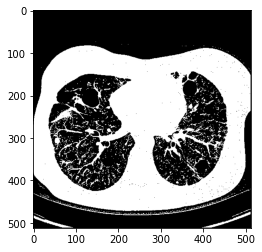

In [3]:
path = "image/ILD/2/gray/FILE0_gray.jpg"
img = cv2.imread(path , 0)
plt.imshow(img , 'gray')
canny = cv2.Canny(img , 30 , 150)

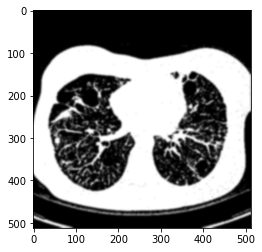

In [4]:
blurred = cv2.GaussianBlur(img, (11, 11), 0)#高斯模糊化
plt.imshow(blurred , 'gray')

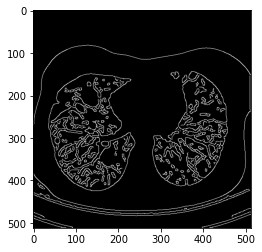

In [5]:
canny = cv2.Canny(blurred , 30 , 150)
plt.imshow(canny , 'gray')

In [266]:
def mask(rootpath , image , count):
    path = rootpath + "/gray/" + image
    img = cv2.imread(path , 0)
    # blurred = cv2.GaussianBlur(img, (11, 11), 0)#高斯模糊化
    canny = cv2.Canny(img , 30 , 150)#threshold_one and threshold_two
    # canny = cv2.Canny(img , 30 , 150)
    canny = cv2.dilate(canny , None)
    canny = cv2.erode(canny , None)

    #Parameter 
    BLUR = 21
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0 , 0.0 , 0.0) #In RGB format

    contour_info = []
    contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))

    contour_info = sorted(contour_info , key = lambda c: c[2] , reverse = True)

    #create empty mask, draw filled polygon on its corresponding to largest contour
    #Mask is black, polygon is white
    mask = np.zeros(canny.shape)
    max_contour = contour_info[count-1]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[3]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[2]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))

    #smooth mask then blur it
    mask = cv2.dilate(mask , None , iterations = MASK_DILATE_ITER)
    mask = cv2.erode(mask , None , iterations = MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask , (BLUR , BLUR) , 0)
    
    plt.subplot(3,3,count),plt.imshow(mask)
def segmentation(rootpath , image):
#     path = "image/ILD/06753077/gray/FILE0_gray.jpg"
    path = rootpath + "/gray/" + image
    img = cv2.imread(path , 0)
    # blurred = cv2.GaussianBlur(img, (11, 11), 0)#高斯模糊化
    canny = cv2.Canny(img , 30 , 150)#threshold_one and threshold_two
    # canny = cv2.Canny(img , 30 , 150)
    canny = cv2.dilate(canny , None)
    canny = cv2.erode(canny , None)

    #Parameter 
    BLUR = 21
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0 , 0.0 , 0.0) #In RGB format

    contour_info = []
    contours,_ = cv2.findContours(canny , cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
#     contours,_ = cv2.findContours(canny , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))

    contour_info = sorted(contour_info , key = lambda c: c[2] , reverse = True)

    #create empty mask, draw filled polygon on its corresponding to largest contour
    #Mask is black, polygon is white
    mask = np.zeros(canny.shape)
#     max_contour = contour_info[0]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[1]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))  
    max_contour = contour_info[2]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))
    max_contour = contour_info[3]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[4]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[5]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[6]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
#     max_contour = contour_info[7]
#     cv2.fillConvexPoly(mask , max_contour[0] , (255))
    max_contour = contour_info[8]
    cv2.fillConvexPoly(mask , max_contour[0] , (255))


    #smooth mask then blur it
    mask = cv2.dilate(mask , None , iterations = MASK_DILATE_ITER)
    mask = cv2.erode(mask , None , iterations = MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask , (BLUR , BLUR) , 0)
    
    
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    img = img[: , : , np.newaxis]
    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    originalfilename = image.split('_')[0]
    temp1 = cv2.imread((rootpath + originalfilename + '.jpg') , 0)
    temp1 = temp1.astype('float32') / 255.0
    temp = temp1[: , : , np.newaxis]
    org = mask_stack * temp + ((1-mask_stack) * MASK_COLOR)
    org = (org * 255).astype('uint8')
    # cv2.imshow('img' , masked)       # Display
#     plt.imshow(org , 'gray')
    plt.subplot(1,3,1)
    plt.imshow(mask)
    plt.subplot(1,3,2)
    plt.imshow(org , 'gray')
    plt.subplot(1,3,3)
    plt.imshow(masked)
    cv2.imwrite(rootpath+ "/Segmentation/3_" + str((int)(image.split('E')[1].split('_')[0]) + 1) + ".jpg" , org)
#     plt.imshow(temp , 'gray')
#     cv2.imwrite((rootpath + "/mask/test.jpg") , mask_stack)
    cv2.imwrite((rootpath + "/mask/" + image.split('.')[0] + "_masked.jpg"), masked)
    # cv2.waitKey()

    # plt.imshow(canny , 'gray')

91
image/ILD/3/
FILE71_gray.jpg
72


IndexError: list index out of range

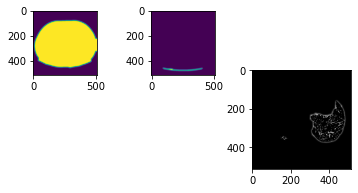

In [267]:
path = "image/ILD/3/"#change XXX to specific folder
des_path = path + "/mask" 
if not os.path.isdir(des_path):#create mask file in each image file
    os.mkdir(des_path)
imagelist = []
filename = r".jpg"#confirm the file name end with jpg
for file in os.listdir((path + "/gray")):
    if file.endswith(filename):
        imagelist.append(file)
print(len(imagelist))
print(path)
image_path = path + "/gray"
count = 0
# for image in imagelist:
#     print(count)
#     print(image)
#     count = count + 1
for image in imagelist[68:72]: #imagelist 為 jpg 檔的名稱
    image = imagelist[68]
    print(image)
    print(str((int)(image.split('E')[1].split('_')[0]) + 1))
#     print(str(cc) + '1')
    segmentation(path , image)
    for i in range(1 , 10):
        mask(path , image , i)
# print(path)
# segmentation(path , 'temp.jpg')

In [91]:
count = 0
for image in imagelist:
    print(count)
    count = count + 1
    print(image)

0
FILE0_gray.jpg
1
FILE10_gray.jpg
2
FILE11_gray.jpg
3
FILE12_gray.jpg
4
FILE13_gray.jpg
5
FILE14_gray.jpg
6
FILE15_gray.jpg
7
FILE16_gray.jpg
8
FILE17_gray.jpg
9
FILE18_gray.jpg
10
FILE19_gray.jpg
11
FILE1_gray.jpg
12
FILE20_gray.jpg
13
FILE21_gray.jpg
14
FILE22_gray.jpg
15
FILE23_gray.jpg
16
FILE24_gray.jpg
17
FILE25_gray.jpg
18
FILE26_gray.jpg
19
FILE27_gray.jpg
20
FILE28_gray.jpg
21
FILE29_gray.jpg
22
FILE2_gray.jpg
23
FILE30_gray.jpg
24
FILE31_gray.jpg
25
FILE32_gray.jpg
26
FILE33_gray.jpg
27
FILE34_gray.jpg
28
FILE35_gray.jpg
29
FILE36_gray.jpg
30
FILE37_gray.jpg
31
FILE38_gray.jpg
32
FILE39_gray.jpg
33
FILE3_gray.jpg
34
FILE40_gray.jpg
35
FILE41_gray.jpg
36
FILE42_gray.jpg
37
FILE43_gray.jpg
38
FILE44_gray.jpg
39
FILE45_gray.jpg
40
FILE46_gray.jpg
41
FILE47_gray.jpg
42
FILE48_gray.jpg
43
FILE49_gray.jpg
44
FILE4_gray.jpg
45
FILE50_gray.jpg
46
FILE51_gray.jpg
47
FILE52_gray.jpg
48
FILE53_gray.jpg
49
FILE54_gray.jpg
50
FILE55_gray.jpg
51
FILE56_gray.jpg
52
FILE57_gray.jpg
53
FILE5

In [87]:
path = "image/ILD/12077743"
des_path = path + "/mask" 
if not os.path.isdir(des_path):#create mask file in each image file
    os.mkdir(des_path)
imagelist = []
filename = r".jpg"#confirm the file name end with jpg
for file in os.listdir((path + "/gray")):
    if file.endswith(filename):
        imagelist.append(file)
print(len(imagelist))

FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'image/ILD/12077743/mask'